In [1]:
import pandas as pd
import eurostat

In [2]:
df = eurostat.get_data_df(code="HBS_STR_T225")
df = df.rename(columns={'geo\TIME_PERIOD': 'geo', '2015':'OBS_VALUE'})

In [3]:
discriminatoryColumn = "age"
firstCat = "Y_LT30"
lastCat = "Y_GE60"

In [4]:
# Keep only the rows where TIME_PERIOD is equal to 2015
df = df.loc[:, [discriminatoryColumn,'coicop','geo','OBS_VALUE']]


In [5]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR",filter_pars={'startPeriod':"2021-01"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})


In [6]:
merged_df = df.merge(df_inflation, on=["coicop", "geo"])


In [7]:
cols_to_multiply = [col for col in merged_df.columns if col.startswith('202')]
merged_df[['w' + col for col in cols_to_multiply]] = merged_df[cols_to_multiply].apply(lambda x: x * merged_df['OBS_VALUE']/1000)


In [8]:
merged_df_5_chars = merged_df[merged_df['coicop'].str.len() == 5]


In [9]:
columns_to_sum = [col for col in merged_df_5_chars.columns if col.startswith('w')]
                  
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', discriminatoryColumn])[col].transform('sum')

df_inflation_by_category = merged_df_5_chars[['geo', discriminatoryColumn] + summed_columns].drop_duplicates()

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\888901905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', discriminatoryColumn])[col].transform('sum')
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\888901905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', discriminatoryColumn])[col].transform('sum')
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\888

In [10]:
# For EU27_2020, only the groups of coicop with 4 characters have value

merged_df_4_chars = merged_df[merged_df['coicop'].str.len() == 4]
merged_df_4_chars = merged_df_4_chars.loc[(merged_df_4_chars['geo'] == 'EU27_2020')]
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_4_chars[new_col_name] = merged_df_4_chars.groupby(['geo', discriminatoryColumn])[col].transform('sum')

df_inflation_by_category_eu27 = merged_df_4_chars[['geo', discriminatoryColumn] + summed_columns].drop_duplicates()


In [11]:
df_inflation_by_category = pd.concat([df_inflation_by_category, df_inflation_by_category_eu27])

In [12]:
# we drop Italy and EA because they don't have the values, and TR because they have a crazy high inflation
df_inflation_by_category = df_inflation_by_category.loc[~df_inflation_by_category['geo'].isin(['IT', 'EA', 'TR'])]

In [13]:
value_vars = df_inflation_by_category.filter(regex='^202').columns


In [14]:
df_inflation_by_category_melt = df_inflation_by_category.melt(id_vars=["geo", discriminatoryColumn], value_vars=value_vars, var_name="month", value_name="inflation")

In [15]:
df_pivot = df_inflation_by_category_melt.pivot_table(index=['geo', 'month'], columns=discriminatoryColumn, values='inflation').reset_index()

df_pivot[f'{firstCat}/{lastCat}'] = df_pivot[f'{firstCat}'] / df_pivot[f'{lastCat}']


df_pivot[f'{firstCat}-{lastCat}'] = df_pivot[f'{firstCat}'] - df_pivot[f'{lastCat}']

df_inflation_by_category = df_pivot.reset_index(drop=True)
df_inflation_by_category = df_inflation_by_category.drop(["UNK"], axis=1)

# Overall inflation

In [16]:
df_inflation_total = df_inflation[df_inflation["coicop"] == "CP00"]

In [17]:
df_inflation_total = df_inflation_total.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationTOT")

In [18]:
df_inflation_by_category = df_inflation_by_category.merge(df_inflation_total, on=["geo", "month"])

# Energy inflation

In [19]:
df_inflation_NRG = df_inflation[df_inflation["coicop"] == "NRG"]

In [20]:
df_inflation_NRG = df_inflation_NRG.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationNRG")

In [21]:
df_inflation_by_category = df_inflation_by_category.merge(df_inflation_NRG, on=["geo", "month"])

In [22]:
df_inflation_by_category['inflationNRG/TOT'] = df_inflation_by_category['inflationNRG'] / df_inflation_by_category['inflationTOT']

# Food inflation

In [23]:
df_inflation_FOOD = df_inflation[df_inflation["coicop"] == "FOOD"]

In [24]:
df_inflation_FOOD = df_inflation_FOOD.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationFOOD")

In [25]:
df_inflation_by_category = df_inflation_by_category.merge(df_inflation_FOOD, on=["geo", "month"])

# Services inflation

In [26]:
df_inflation_SERV = df_inflation[df_inflation["coicop"] == "SERV"]

In [27]:
df_inflation_SERV = df_inflation_SERV.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationSERV")

In [28]:
df_inflation_by_category = df_inflation_by_category.merge(df_inflation_SERV, on=["geo", "month"])

In [29]:
df_inflation_by_category['inflationNRG/SERV'] = df_inflation_by_category['inflationNRG'] / df_inflation_by_category['inflationSERV']

# Gini

In [30]:
gini = eurostat.get_data_df(code="TESSI190")

In [31]:
import numpy as np

def get_most_recent(row):
    for year in range(2022, 2010, -1):
        if not pd.isnull(row[str(year)]):
            return row[str(year)]
    return np.nan

gini["most_recent"] = gini.apply(get_most_recent, axis=1)
gini = gini.rename(columns={"geo\TIME_PERIOD": "geo"})
gini = gini.loc[:, ["geo", "most_recent"]]
gini = gini.rename(columns={"most_recent": "gini"})


In [32]:
df_inflation_by_category = df_inflation_by_category.merge(gini, on="geo")

# Price levels

In [33]:
price_levels_energy = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A010405"], "na_item":"PLI_EU27_2020"})
price_levels_energy = price_levels_energy.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "energy_price_level"})
price_levels_energy = price_levels_energy.loc[:, ["geo", "energy_price_level"]]



In [34]:
df_inflation_by_category = df_inflation_by_category.merge(right=price_levels_energy, on="geo")

In [35]:
price_levels_transport = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A0107"], "na_item":"PLI_EU27_2020"})
price_levels_transport = price_levels_transport.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "transport_price_level"})
price_levels_transport = price_levels_transport.loc[:, ["geo", "transport_price_level"]]

In [36]:
df_inflation_by_category = df_inflation_by_category.merge(right=price_levels_transport, on="geo")

# GDP per capita

In [37]:
code = "NAMA_10_PC"
gdp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "unit": "CP_EUR_HAB", "na_item":"B1GQ"})
gdp = gdp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gdp"})
gdp = gdp.loc[:, ["geo", "gdp"]]

In [38]:
df_inflation_by_category = df_inflation_by_category.merge(right=gdp, on="geo")

# Government expenditure

In [39]:
code = "GOV_10A_EXP"
gov_exp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "TOTAL"})
gov_exp = gov_exp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp"})
gov_exp = gov_exp.loc[:, ["geo", "gov_exp"]]

In [40]:
df_inflation_by_category = df_inflation_by_category.merge(right=gov_exp, on="geo")

In [41]:
code = "GOV_10A_EXP"
gov_exp_social = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "GF10"})
gov_exp_social = gov_exp_social.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp_social"})
gov_exp_social = gov_exp_social.loc[:, ["geo", "gov_exp_social"]]

In [42]:
df_inflation_by_category = df_inflation_by_category.merge(right=gov_exp_social, on="geo")

# Urbanisation

In [43]:
code = "ILC_LVHO01"
urbanisation = eurostat.get_data_df(code=code, filter_pars={"endPeriod":"2022", "incgrp":"TOTAL", "building": "TOTAL", "deg_urb": "DEG1"})

urbanisation["most_recent"] = urbanisation.apply(get_most_recent, axis=1)


urbanisation = urbanisation.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "urbanisation"})
urbanisation = urbanisation.loc[:, ["geo", "urbanisation"]]

In [44]:
df_inflation_by_category = df_inflation_by_category.merge(urbanisation, on="geo")

# Share of electric consumption in final energy consumption

In [45]:
code = "NRG_IND_FECF"
electric_share = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2021", "endPeriod":"2021", "nrg_bal":"FC_E","siec":"E7000"})



electric_share = electric_share.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "electric_share"})
electric_share = electric_share.loc[:, ["geo", "electric_share"]]

In [46]:
df_inflation_by_category = df_inflation_by_category.merge(electric_share, on="geo")

# At-risk-of-poverty rate before social transfers

In [47]:
code = "ILC_LI10"
poverty = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2022", "age": "total", "indic_il":"LI_R_MD60BT", "sex":"T"})

poverty["most_recent"] = poverty.apply(get_most_recent, axis=1)


poverty = poverty.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "poverty"})
poverty = poverty.loc[:, ["geo", "poverty"]]

In [48]:
df_inflation_by_category = df_inflation_by_category.merge(poverty, on="geo")

# Import

In [49]:
code = "TET00004"
importation = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2021"})


importation = importation.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "importation"})
importation = importation.loc[:, ["geo", "importation"]]

In [50]:
df_inflation_by_category = df_inflation_by_category.merge(importation, on="geo")

# Analysis

# Auto regressive

In [51]:
import statsmodels.api as sm


# Replace infinite values with NaN
df_inflation_by_category = df_inflation_by_category.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values and 0 values
df_inflation_by_category = df_inflation_by_category.dropna()
df_inflation_by_category = df_inflation_by_category[df_inflation_by_category != 0].dropna()

# Define the maximum number of lags
max_lag = 4

# Create an empty DataFrame to store the lagged values
df_lagged = pd.DataFrame()

# Loop through each region and add the lagged values to the DataFrame
for geo in df_inflation_by_category['geo'].unique():
    # Subset the data for the current region
    df_region = df_inflation_by_category[df_inflation_by_category['geo']==geo]
    # Add the lagged values to the DataFrame for the current region
    for i in range(1, max_lag+1):
        df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
    # Append the lagged values for the current region to the overall DataFrame
    df_lagged = pd.concat([df_lagged, df_region], ignore_index=True)

# Remove rows with missing values
df_lagged = df_lagged.dropna()

# Select target variable and explanatory variables, including the lagged values
X = df_lagged[['inflationNRG/SERV','gov_exp_social', 'inflationNRG/TOT', 'gini', 'urbanisation', 'poverty', 'electric_share', 'importation', f'{firstCat}-{lastCat}_lag1', f'{firstCat}-{lastCat}_lag2', f'{firstCat}-{lastCat}_lag3', f'{firstCat}-{lastCat}_lag4']]

Y = df_lagged[f'{firstCat}-{lastCat}']

# Add a constant to the explanatory variables
# X = sm.add_constant(X)

# Fit the AR model
model = sm.OLS(Y, X).fit()

summary = model.summary()
# Print the summary of results
print(summary)

html_summary = summary.as_html()
with open('saved_figs/model_summary3.html', 'w') as f:
    f.write(html_summary)


                                 OLS Regression Results                                
Dep. Variable:          Y_LT30-Y_GE60   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              300.2
Date:                Wed, 10 May 2023   Prob (F-statistic):                   4.81e-245
Time:                        16:16:00   Log-Likelihood:                         -360.72
No. Observations:                 615   AIC:                                      745.4
Df Residuals:                     603   BIC:                                      798.5
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\1767515756.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\1767515756.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\1767515756.py:23: SettingWithCopyWarning: 
A valu

In [52]:
import statsmodels.api as sm


# Replace infinite values with NaN
df_inflation_by_category = df_inflation_by_category.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values and 0 values
df_inflation_by_category = df_inflation_by_category.dropna()
df_inflation_by_category = df_inflation_by_category[df_inflation_by_category != 0].dropna()

# Define the maximum number of lags
max_lag = 4

# Create an empty DataFrame to store the lagged values
df_lagged = pd.DataFrame()

# Loop through each region and add the lagged values to the DataFrame
for geo in df_inflation_by_category['geo'].unique():
    # Subset the data for the current region
    df_region = df_inflation_by_category[df_inflation_by_category['geo']==geo]
    # Add the lagged values to the DataFrame for the current region
    for i in range(1, max_lag+1):
        df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
    # Append the lagged values for the current region to the overall DataFrame
    df_lagged = pd.concat([df_lagged, df_region], ignore_index=True)

# Remove rows with missing values
df_lagged = df_lagged.dropna()

# Select target variable and explanatory variables, including the lagged values
X = df_lagged[['inflationNRG/SERV','gov_exp_social', 'inflationNRG/TOT', 'gini', 'urbanisation', 'poverty', 'electric_share', 'importation']]

Y = df_lagged[f'{firstCat}-{lastCat}']


# Fit the AR model
model = sm.OLS(Y, X).fit()

summary = model.summary()
# Print the summary of results
print(summary)


                                 OLS Regression Results                                
Dep. Variable:          Y_LT30-Y_GE60   R-squared (uncentered):                   0.110
Model:                            OLS   Adj. R-squared (uncentered):              0.099
Method:                 Least Squares   F-statistic:                              9.408
Date:                Wed, 10 May 2023   Prob (F-statistic):                    2.71e-12
Time:                        16:16:01   Log-Likelihood:                         -922.03
No. Observations:                 615   AIC:                                      1860.
Df Residuals:                     607   BIC:                                      1895.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\2607850834.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\2607850834.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region[f'{firstCat}-{lastCat}_lag{i}'] = df_region[f'{firstCat}-{lastCat}'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_13216\2607850834.py:23: SettingWithCopyWarning: 
A valu

# AutoReg

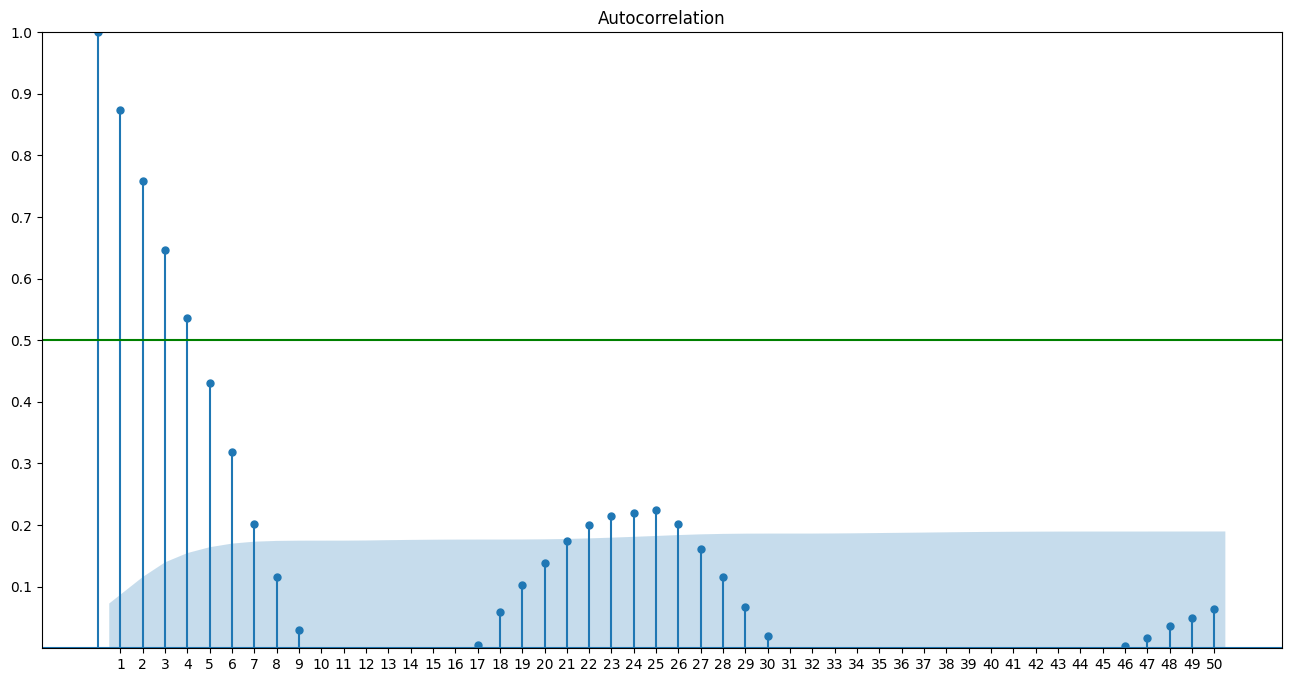

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

df = df_inflation_by_category
fig, ax = plt.subplots(figsize=(16,8))
plot_acf(df[f'{firstCat}-{lastCat}'], lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")
plt.show()

In [54]:
import pandas as pd
from statsmodels.tsa.api import AutoReg

# Charger les données
df = df_inflation_by_category

# Formater les données pour être utilisées dans AutoReg
df = df.set_index(['month', 'geo'])
Y = df[f'{firstCat}-{lastCat}']
X = df[["inflationNRG/SERV", "gov_exp_social"]]

# Définir les paramètres du modèle
lags = 4  # nombre de lags
trend = 'c'  # tendance ('c' constante, 't' linéaire, None aucune)

# Créer le modèle AutoReg et l'ajuster aux données
model = AutoReg(Y, lags=lags, trend=trend, exog=X)
results = model.fit()

# Vérifier les résultats
print(results.summary())


                            AutoReg Model Results                             
Dep. Variable:          Y_LT30-Y_GE60   No. Observations:                  727
Model:                   AutoReg-X(4)   Log Likelihood                -532.048
Method:               Conditional MLE   S.D. of innovations              0.505
Date:                Wed, 10 May 2023   AIC                           1080.096
Time:                        16:16:01   BIC                           1116.763
Sample:                             4   HQIC                          1094.249
                                  727                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0601      0.084     -0.715      0.475      -0.225       0.105
Y_LT30-Y_GE60.L1      0.8821      0.037     23.835      0.000       0.810       0.955
Y_LT30-Y_GE60.L2      0.

c:\Users\mdaversa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
